# Telco Customer Churn IBM #

## 1. Introducción ##

El Objetivo es dimnuir el Churn reflejado en la variable Customer Status con el fin de incrementar las ganancias. Para esto, procede hacer una limpieza de datos, una analís exploratorio, una ingeniería de características para aplicar modelos predictivos y finalmente proponer soluciones. Asimimos, los campos Churn Category y Churn Reason permiten aplicar estrategías intentar retener a lois clientes. Dado que, los árboles son útiles con datos tabulares y simplican algunas tareas como la ingeniera de características, se propone inicialmente este modelo. 



In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, accuracy_score,
                           precision_score, recall_score, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import xgboost as xgb

import itertools

from scipy.stats import chi2_contingency
import warnings

from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from scipy.stats import pearsonr, chi2_contingency, kruskal

import warnings



warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

1. Carga de datos

In [156]:
df_test = pd.read_csv('base_telco.csv')


## 2. Estado inicial de los datos

En los datos, se observan faltantes debido a que en Churn Category y Churn Reason solo aplica a los clientes que se fueron; esto mismo pasa con las variables relacionadas a los servicios de internet y a los servicios de teléfono. Por último, la característica oferta es faltante cuando el cliente no aceptado ninguna oferta.

In [157]:
df_test.head(5)


,Customer ID,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,2,9,NaN,Yes,42.39,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,0,9,NaN,Yes,10.69,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,0,4,Offer E,Yes,33.65,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,1,13,Offer D,Yes,27.82,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,3,3,NaN,Yes,7.38,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [158]:
# Análisis de datos faltantes por columna en el dataset df_test
missing_data = df_test.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print("Cantidad de datos faltantes por columna en df_test:")
# Convertir los datos faltantes a un DataFrame y mostrarlo
missing_data_df = missing_data.reset_index()
missing_data_df.columns = ['Columna', 'Cantidad de Faltantes']
missing_data_df




Cantidad de datos faltantes por columna en df_test:


,Columna,Cantidad de Faltantes
0,Churn Category,5174
1,Churn Reason,5174
2,Offer,3877
3,Online Security,1526
4,Online Backup,1526
5,Avg Monthly GB Download,1526
6,Internet Type,1526
7,Streaming Movies,1526
8,Streaming TV,1526
9,Device Protection Plan,1526


In [159]:
# Identificar columnas numéricas y categóricas, excluyendo el id del cliente
cols_excluir = ['Customer ID']
categorical_cols = [col for col in df_test.select_dtypes(include=['object', 'category']).columns if col not in cols_excluir]
numeric_cols = [col for col in df_test.select_dtypes(include=['number']).columns if col not in cols_excluir]

print("Cantidad de columnas categóricas :", len(categorical_cols))
print("Cantidad de columnas numéricas :", len(numeric_cols))



Cantidad de columnas categóricas : 21
Cantidad de columnas numéricas : 12


## 3. Limpieza de datos

Para un mejora trabajo se cambia los nombres de las columnas.

In [160]:
# Cambiar los nombres de las columnas a camelCase
def to_camel_case(s):
    parts = s.strip().replace('_', ' ').replace('-', ' ').split()
    return parts[0].lower() + ''.join(word.capitalize() for word in parts[1:])

df_test.columns = [to_camel_case(col) for col in df_test.columns]

df_test_copy = df_test.copy()

df_test_copy.columns

Index(['customerId', 'gender', 'age', 'married', 'numberOfDependents',
       'numberOfReferrals', 'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
       'churnCategory', 'churnReason'],
      dtype='object')

Se tratan los datos faltantes ya mencionados. En el caso de avgMonthlyGbDownload y avgMonthlyLongDistanceCharges dado que son variables numericas se completa con 0 los faltantes. Por último, se elimina la variable que identifica al cliente customerId

In [161]:
##'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['internetType']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['onlineBackup']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['onlineSecurity']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['deviceProtectionPlan']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['premiumTechSupport']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingTv']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingMovies']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingMusic']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['unlimitedData']] = 'NoInternetService'

##sino tengo servicio de internet el este valor es 0
df_test_copy.loc[df_test_copy['internetService'] == 'No',['avgMonthlyGbDownload']] = 0

##phoneService
df_test_copy.loc[df_test_copy['phoneService'] == 'No',['avgMonthlyLongDistanceCharges']] = 0
df_test_copy.loc[df_test_copy['phoneService'] == 'No',['multipleLines']] = 'NoPhoneService'

##offer
df_test_copy.loc[df_test_copy['offer'].isna(), 'offer'] = 'NoOfferAccepted'

df_test_copy.loc[df_test_copy['customerStatus'] == 'Stayed', ['churnCategory']] = 'NoChurn'
df_test_copy.loc[df_test_copy['customerStatus'] == 'Stayed', ['churnReason']] = 'NoChurn'
df_test_copy.loc[df_test_copy['customerStatus'] == 'Joined', ['churnCategory']] = 'NoChurn'
df_test_copy.loc[df_test_copy['customerStatus'] == 'Joined', ['churnReason']] = 'NoChurn'

#df_test_copy.loc[df_test_copy['internetService'] == 'No',['internetService',
#       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
#       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
#       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
#       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
#       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
#       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
#       'churnCategory', 'churnReason']]

##no tiomar en cuenta el customerid
df_test_copy = df_test_copy.drop(columns=['customerId'])
                                                          
##junsta los nuevos con los viejes y que se queden, EDA

Se comprueba que no quedan datos faltante

In [162]:
# Obtener nombres de columnas, tipos de dato y cantidad de datos vacíos, ordenado por datos faltantes
def resumen_columnas(df):
    resumen = pd.DataFrame({
        'Tipo de Dato': df.dtypes,
        'Datos Faltantes': df.isnull().sum(),
        'Porcentaje Faltantes': df.isnull().mean() * 100
    })
    resumen = resumen.sort_values(by='Datos Faltantes', ascending=False)
    return resumen

# Ejemplo de uso:
resumen_columnas(df_test_copy)
# Filtrar las columnas con datos faltantes
resumen = resumen_columnas(df_test_copy)
columnas_con_faltantes = resumen[resumen['Datos Faltantes'] > 0].index.tolist()

# Mostrar los valores únicos por cada columna con datos faltantes
for col in columnas_con_faltantes:
    print(f"\nColumna: {col}")
    print(df_test_copy[col].unique())



## 4. Analísis Univariado despúes de la limpieza de datos

Se encontraon monthlyCharge negativos

In [171]:
# Calcular la cantidad de personas con 'Churned'
cantidad_churned = (df_test_copy['customerStatus'] == 'Churned').sum()
# Calcular la cantidad total de personas
cantidad_total = len(df_test_copy)

# Calcular el porcentaje que representa la cantidad de churned sobre el total
porcentaje_cantidad_churned = (cantidad_churned / cantidad_total) * 100 if cantidad_total != 0 else 0

# Calcular el total revenue de todos
total_revenue = pd.to_numeric(df_test_copy['totalRevenue'], errors='coerce').sum()
# Calcular el total revenue de los churned
total_revenue_churned = pd.to_numeric(df_test_copy.loc[df_test_copy['customerStatus'] == 'Churned', 'totalRevenue'], errors='coerce').sum()
# Calcular el porcentaje de revenue que representan los churned
porcentaje_revenue_churned = (total_revenue_churned / total_revenue) * 100 if total_revenue != 0 else 0

print(f"La cantidad de personas con 'Churned' es: {cantidad_churned}")
print(f"La cantidad total de personas es: {cantidad_total}")
print(f"Las personas con 'Churned' representan el {porcentaje_cantidad_churned:.2f}% del total de personas.")
print(f"El total revenue de los 'Churned' es: {total_revenue_churned:.2f}")
print(f"El total revenue general es: {total_revenue:.2f}")
print(f"El revenue de los 'Churned' representa el {porcentaje_revenue_churned:.2f}% del total revenue.")


La cantidad de personas con 'Churned' es: 1869
La cantidad total de personas es: 7043
Las personas con 'Churned' representan el 26.54% del total de personas.
El total revenue de los 'Churned' es: 3684459.82
El total revenue general es: 21371131.69
El revenue de los 'Churned' representa el 17.24% del total revenue.


In [107]:
# Analizar columnas numéricas: contar negativos, calcular media, varianza, máximo y mínimo
df_test_copy['avgMonthlyLongDistanceCharges'] = pd.to_numeric(df_test_copy['avgMonthlyLongDistanceCharges'], errors='coerce')

# Identificar columnas numéricas y no numéricas, excluyendo 'customerId'
columnas_numericas = [col for col in df_test_copy.select_dtypes(include=['number']).columns if col.lower != 'customerId']
columnas_no_numericas = [col for col in df_test_copy.select_dtypes(exclude=['number']).columns if col != 'customerId']


resultados = []

for col in columnas_numericas:
    try:
        # Intentar convertir a numérico (forzar errores a NaN)
        serie = pd.to_numeric(df_test_copy[col], errors='coerce')
        negativos = (serie < 0).sum()
        media = serie.mean()
        varianza = serie.var()
        maximo = serie.max()
        minimo = serie.min()
        resultados.append({
            'Columna': col,
            'Negativos': negativos,
            'Media': round(media, 2) if pd.notnull(media) else None,
            'Varianza': round(varianza, 2) if pd.notnull(varianza) else None,
            'Máximo': maximo,
            'Mínimo': minimo
        })
    except Exception as e:
        print(f"Error procesando columna '{col}': {e}")
        resultados.append({
            'Columna': col,
            'Negativos': None,
            'Media': None,
            'Varianza': None,
            'Máximo': None,
            'Mínimo': None
        })

analisis_numerico = pd.DataFrame(resultados)

print("Resumen de análisis numérico:")
analisis_numerico



Resumen de análisis numérico:


,Columna,Negativos,Media,Varianza,Máximo,Mínimo
0,age,0,46.51,280.57,80.00,19.00
1,numberOfDependents,0,0.47,0.93,9.00,0.00
2,numberOfReferrals,0,1.95,9.01,11.00,0.00
3,tenureInMonths,0,32.39,602.31,72.00,1.00
4,avgMonthlyLongDistanceCharges,0,22.96,238.64,49.99,0.00
5,avgMonthlyGbDownload,0,20.52,416.93,85.00,0.00
6,monthlyCharge,120,63.60,973.74,118.75,-10.00
7,totalCharges,0,2280.38,5135755.18,8684.80,18.80
8,totalRefunds,0,1.96,62.45,49.79,0.00
9,totalExtraDataCharges,0,6.86,630.26,150.00,0.00


Verificación de la formula del totalRevenue, formula es correcta.

In [109]:
# Crear una nueva columna con la diferencia calculada
df_test_copy['revenue_diff_calc'] = (
    pd.to_numeric(df_test_copy['totalCharges'], errors='coerce')
    - pd.to_numeric(df_test_copy['totalRefunds'], errors='coerce')
    + pd.to_numeric(df_test_copy['totalExtraDataCharges'], errors='coerce')
    + pd.to_numeric(df_test_copy['totalLongDistanceCharges'], errors='coerce')
    - pd.to_numeric(df_test_copy['totalRevenue'], errors='coerce')
)

# Contar cuántos valores son diferentes de 0 (ignorando NaN)
diferentes_de_cero = (df_test_copy['revenue_diff_calc'].abs() > 1e-6).sum()

# Calcular media, varianza y máximo de la diferencia (ignorando NaN)
media_dif = df_test_copy['revenue_diff_calc'].mean()
varianza_dif = df_test_copy['revenue_diff_calc'].var()
maximo_dif = df_test_copy['revenue_diff_calc'].max()

print(f"Cantidad de diferencias distintas de 0: {diferentes_de_cero}")
print(f"Media de la diferencia: {media_dif}")
print(f"Varianza de la diferencia: {varianza_dif}")
print(f"Máximo de la diferencia: {maximo_dif}")
# Elimina la columna calculada 'revenue_diff_calc'
if 'revenue_diff_calc' in df_test_copy.columns:
    df_test_copy.drop(columns=['revenue_diff_calc'], inplace=True)

Cantidad de diferencias distintas de 0: 0
Media de la diferencia: 2.9761480484059285e-16
Varianza de la diferencia: 8.365882146151194e-26
Máximo de la diferencia: 1.8189894035458565e-12


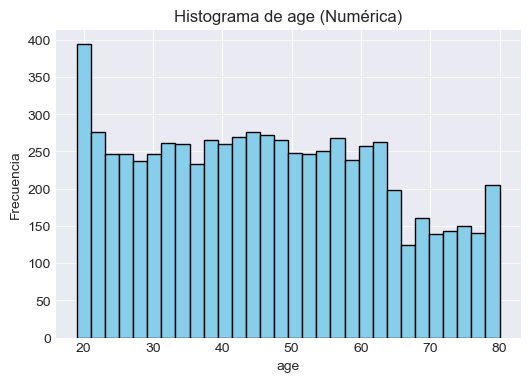

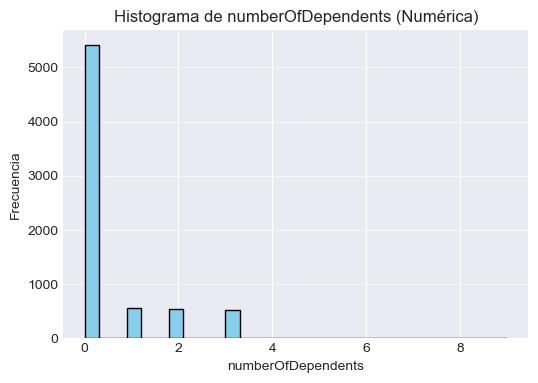

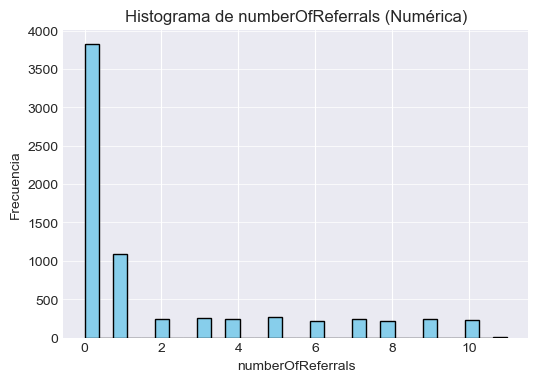

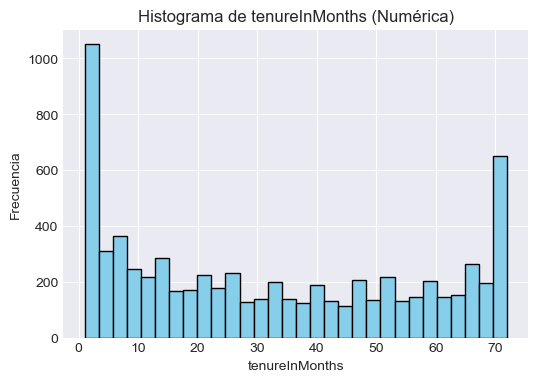

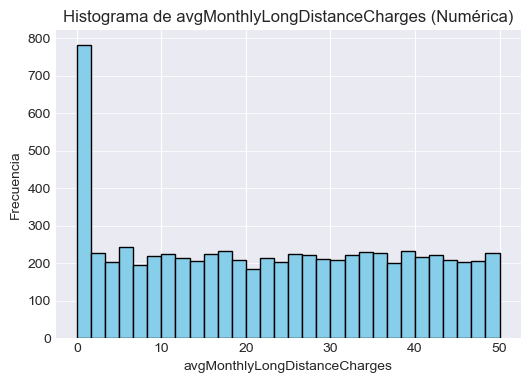

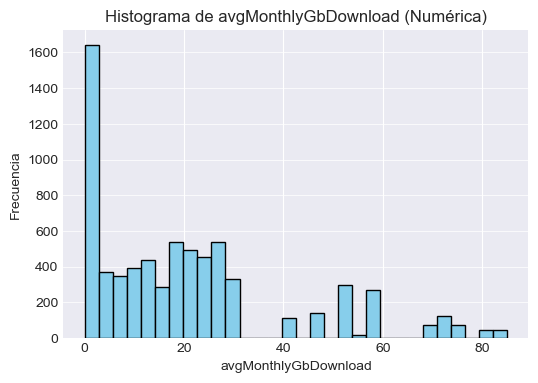

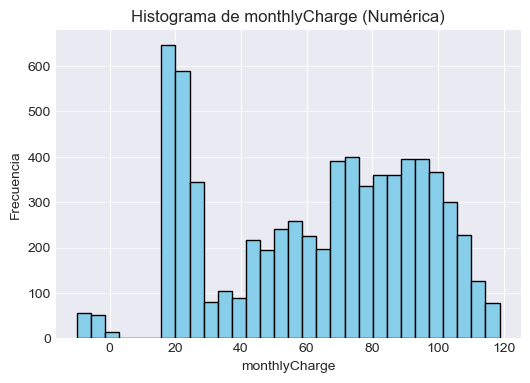

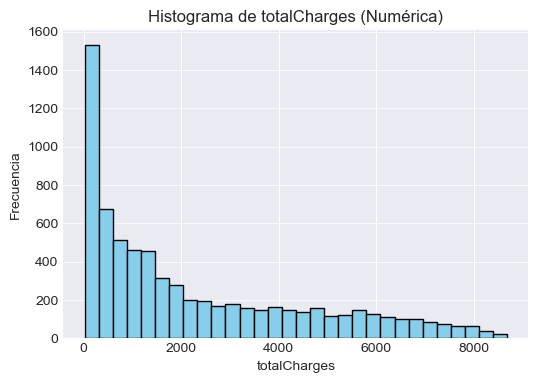

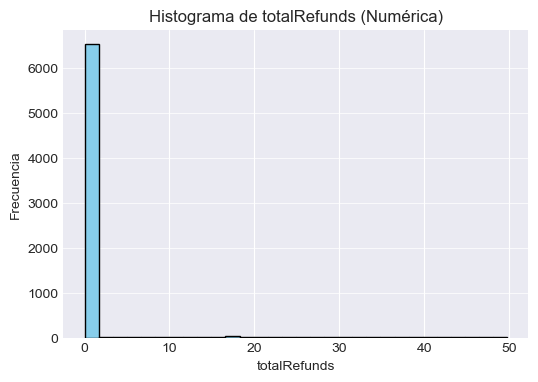

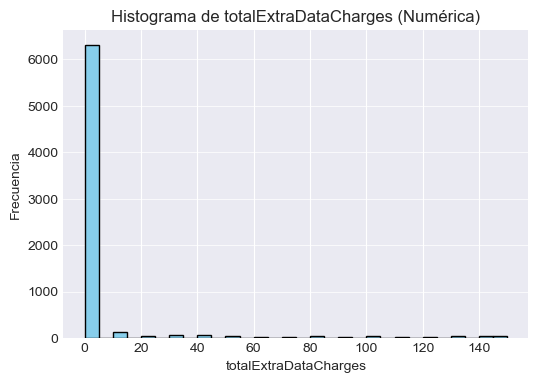

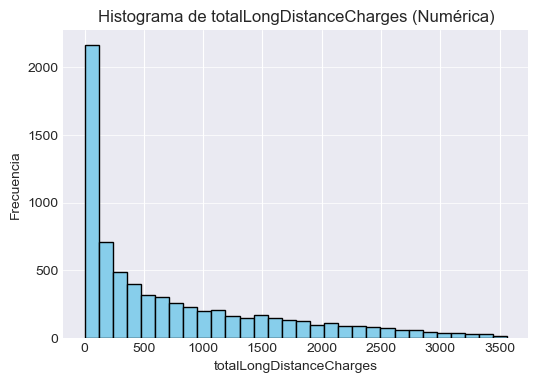

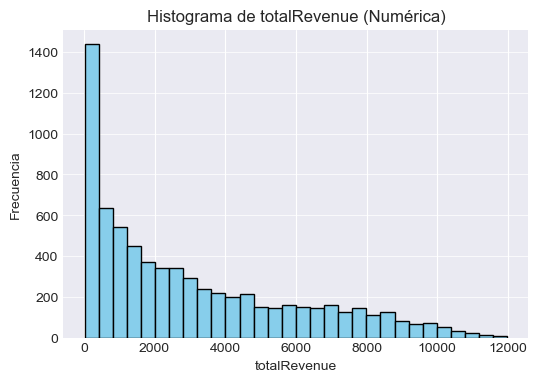

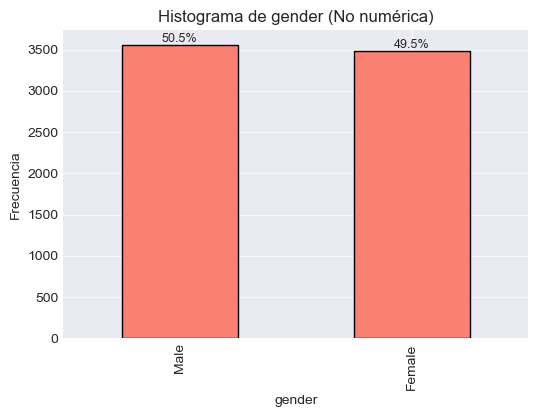

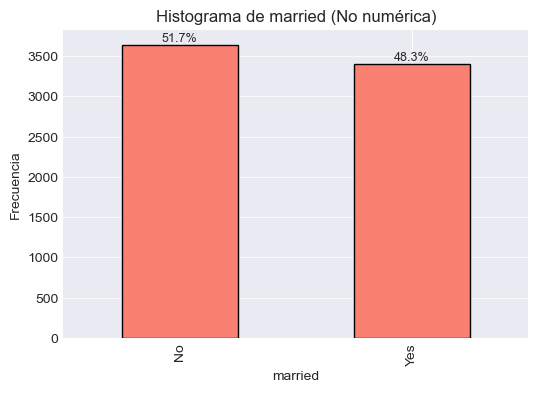

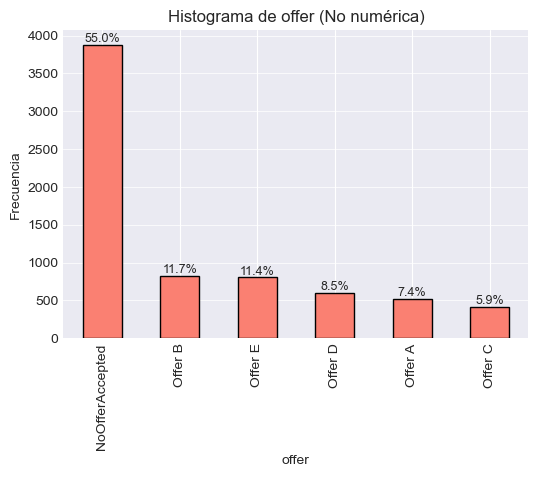

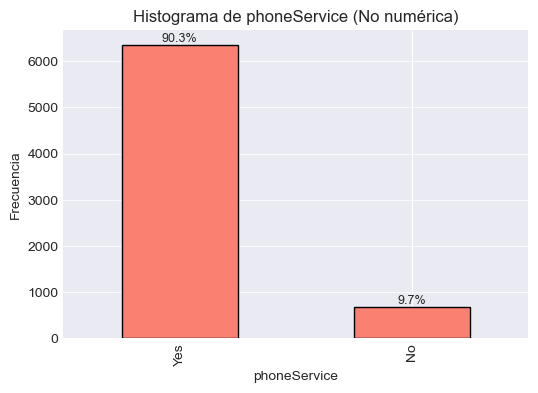

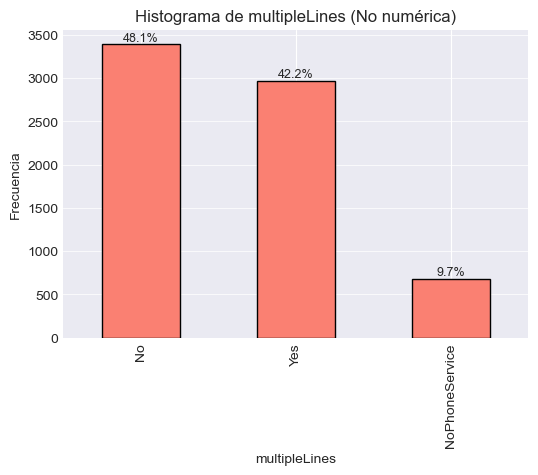

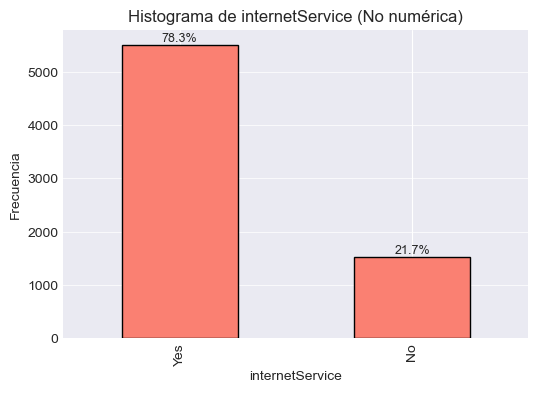

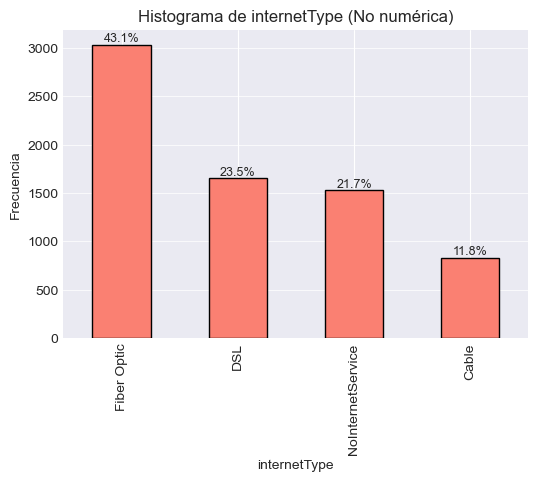

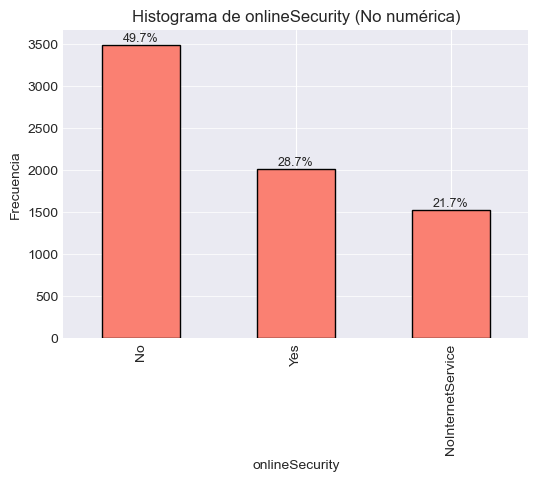

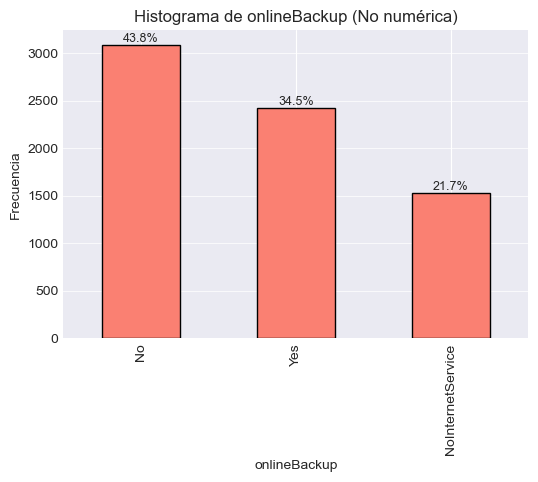

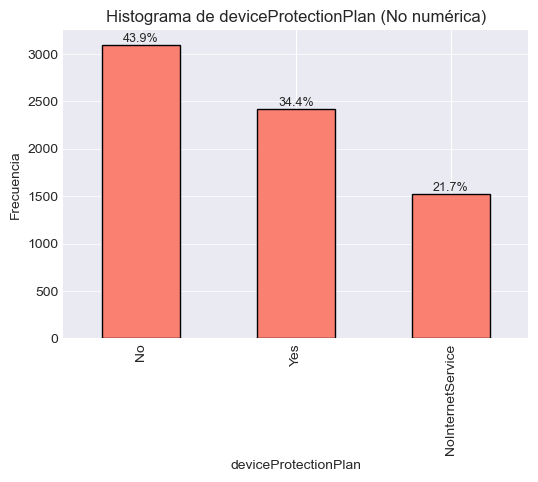

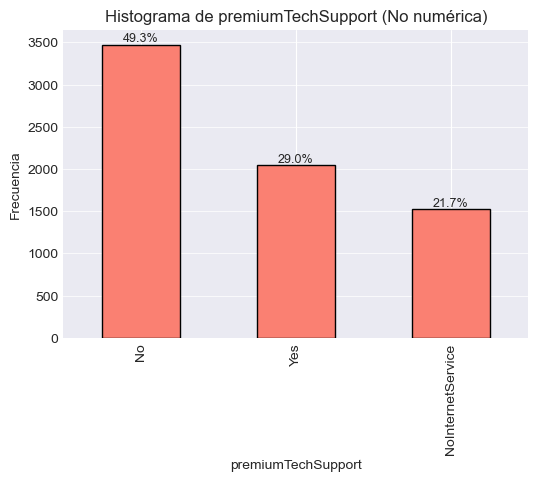

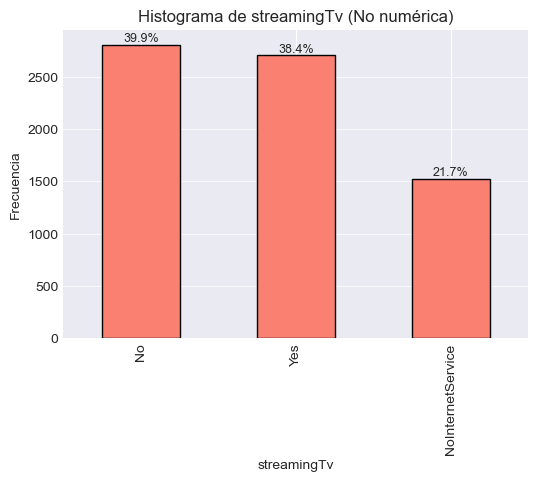

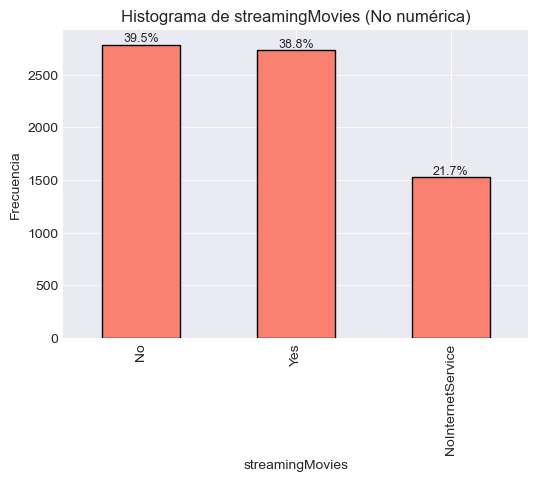

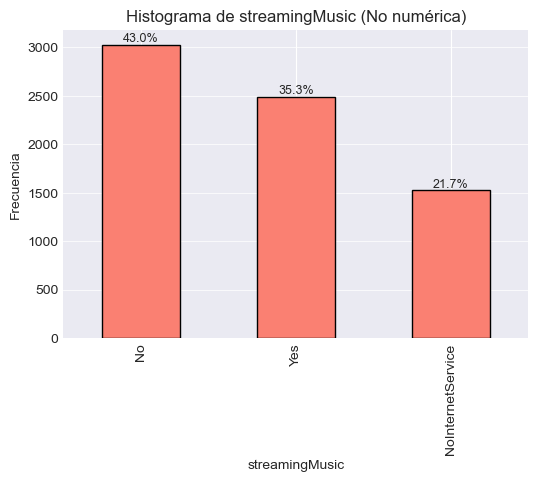

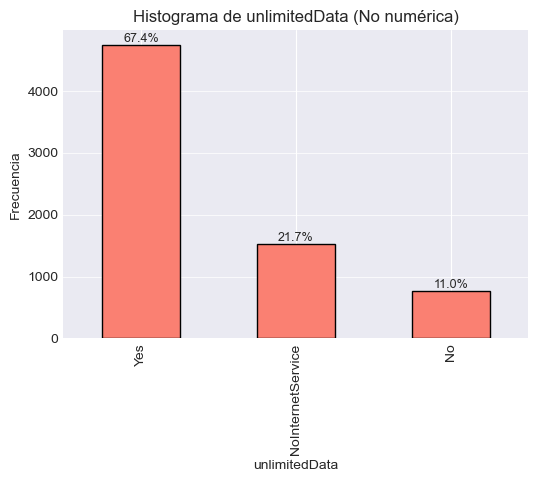

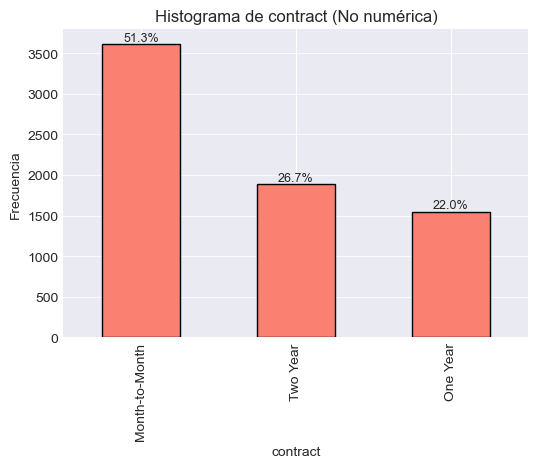

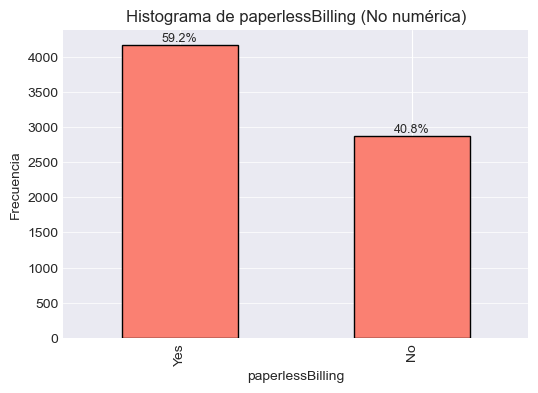

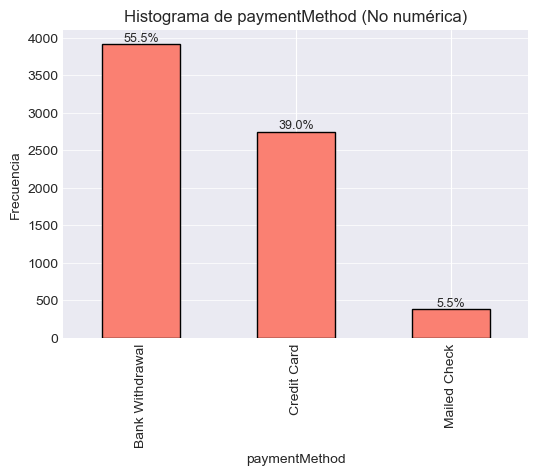

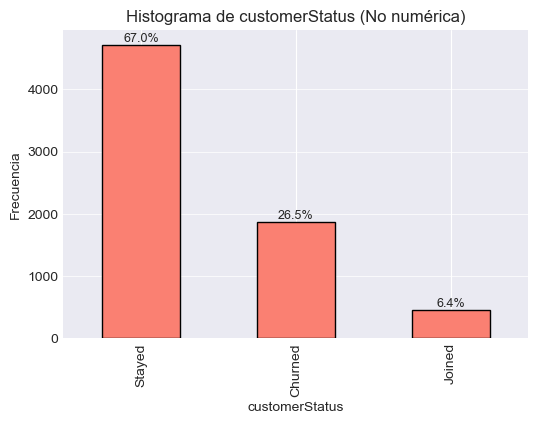

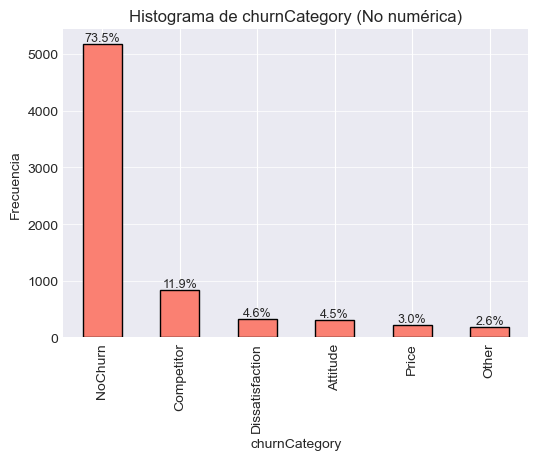

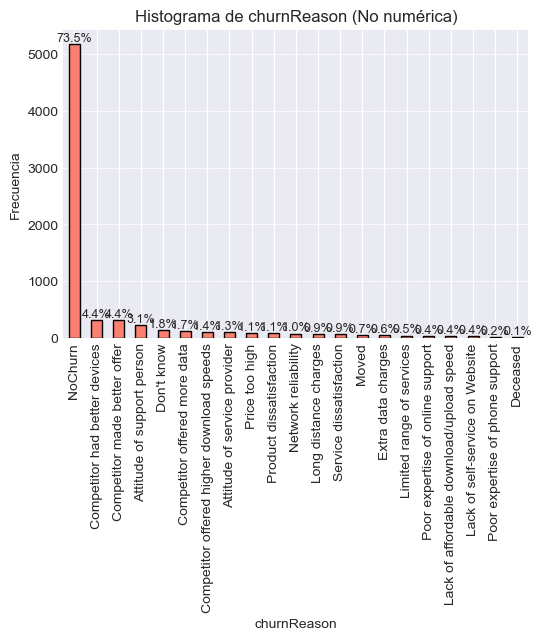

In [110]:
##revisar los datos de las columnas numericas y no numericas

for col in columnas_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 1:
        plt.figure(figsize=(6, 4))
        plt.hist(datos, bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histograma de {col} (Numérica)')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

# Histograma para características no numéricas (usando conteo de frecuencias y mostrando porcentaje)
for col in columnas_no_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 1:
        conteos = datos.value_counts()
        porcentajes = conteos / conteos.sum() * 100
        plt.figure(figsize=(6, 4))
        ax = conteos.plot(kind='bar', color='salmon', edgecolor='black')
        plt.title(f'Histograma de {col} (No numérica)')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.grid(axis='y', alpha=0.75)
        # Agregar porcentaje encima de cada barra
        for i, (idx, valor) in enumerate(conteos.items()):
            porcentaje = porcentajes[idx]
            ax.text(i, valor, f'{porcentaje:.1f}%', ha='center', va='bottom', fontsize=9, rotation=0)
        plt.show()


Ternure, no se han podido registrar ternure mayores a 70, se podría haber agrupado. Comparar cuando si tiene el servicio y cuando no lo tiene para identificar como cambia la variable

### Outliers en datos númericos utilizando el método IQ

Resumen de outliers por columna numérica:


,Columna,Outliers,Total,Porcentaje_Outliers
0,age,0,7043,0.000000
1,numberOfDependents,1627,7043,23.100951
2,numberOfReferrals,676,7043,9.598183
3,tenureInMonths,0,7043,0.000000
4,avgMonthlyLongDistanceCharges,0,7043,0.000000
5,avgMonthlyGbDownload,362,7043,5.139855
6,monthlyCharge,0,7043,0.000000
7,totalCharges,0,7043,0.000000
8,totalRefunds,525,7043,7.454210
9,totalExtraDataCharges,728,7043,10.336504


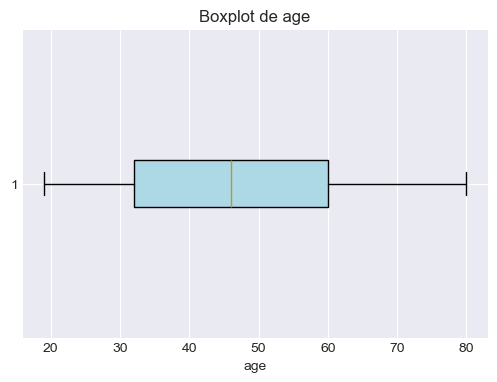

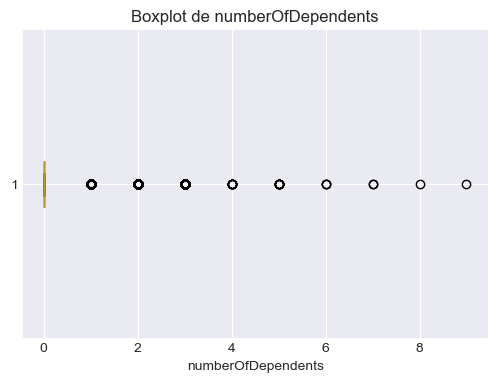

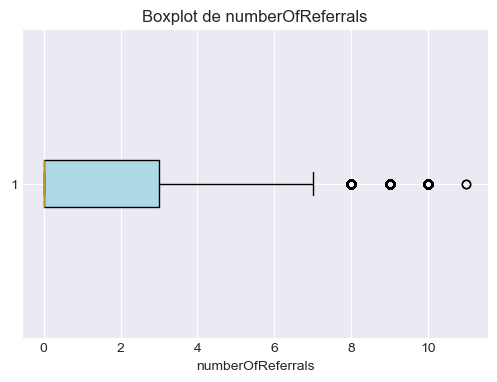

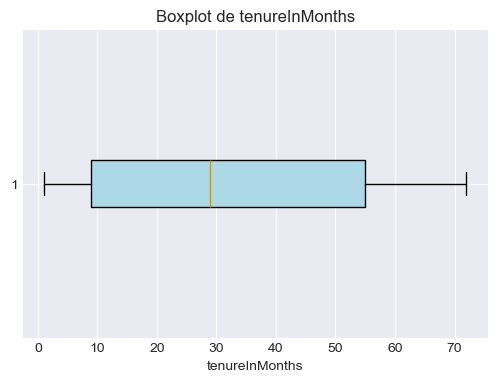

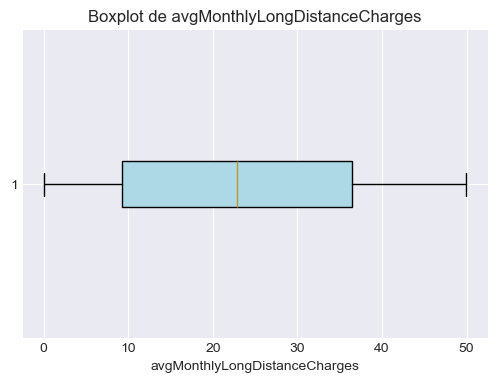

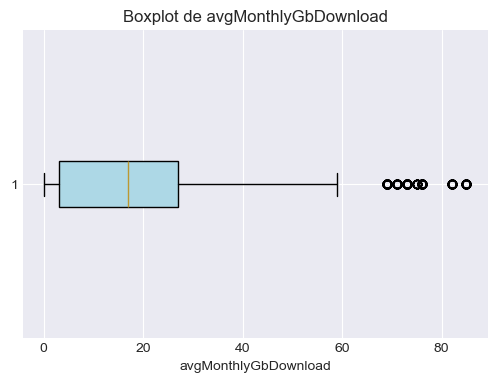

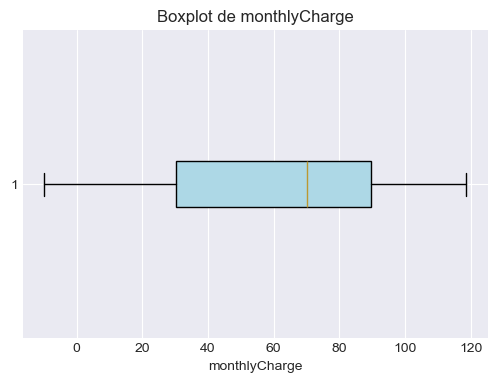

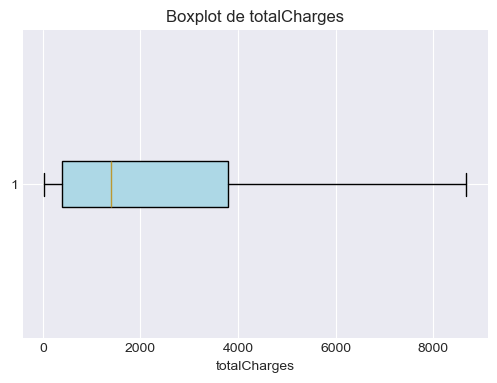

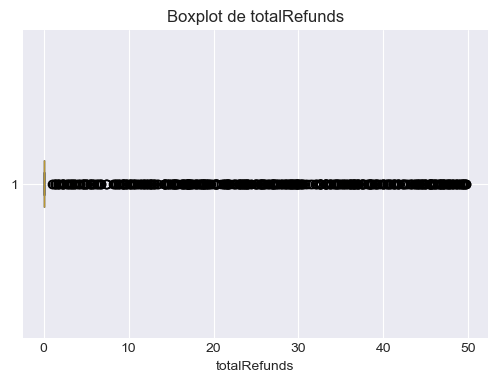

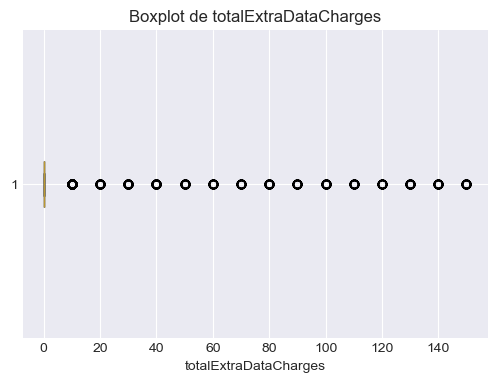

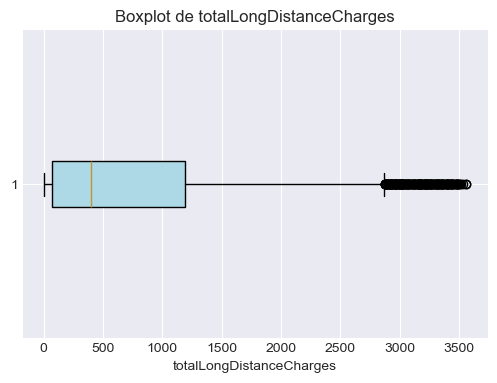

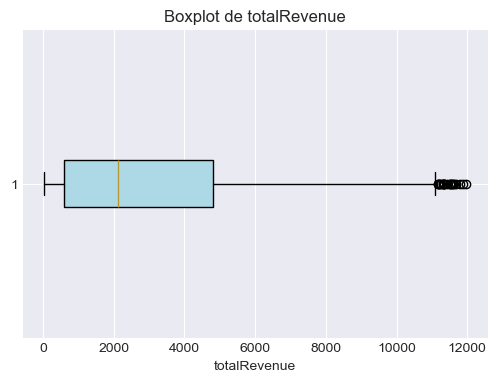

In [113]:
# Análisis de outliers en df_test_copy

# Usaremos el método del rango intercuartílico (IQR) para detectar outliers en las columnas numéricas

outlier_summary = []

for col in columnas_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 0:
        Q1 = datos.quantile(0.25)
        Q3 = datos.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = datos[(datos < lower_bound) | (datos > upper_bound)]
        outlier_count = outliers.count()
        total_count = datos.count()
        outlier_pct = (outlier_count / total_count) * 100 if total_count > 0 else 0
        outlier_summary.append({
            'Columna': col,
            'Outliers': outlier_count,
            'Total': total_count,
            'Porcentaje_Outliers': outlier_pct
        })

outlier_df = pd.DataFrame(outlier_summary)
print("Resumen de outliers por columna numérica:")
display(outlier_df)

# Visualización de outliers con boxplots
for col in columnas_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 0:
        plt.figure(figsize=(6, 4))
        plt.boxplot(datos, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        plt.show()


### Outlier en datos categóricos

Datos que representan menos del 5% del total, solo se observa en churn reason y churn category.



In [114]:
##outalier en datos categori
def detect_rare_categories(df, column, threshold=0.05):
    """
    Detecta categorías que aparecen menos del threshold% de las veces
    """
    value_counts = df[column].value_counts(normalize=True)
    rare_categories = value_counts[value_counts < threshold].index.tolist()
    
    for cat in rare_categories:
        count = df[column].value_counts()[cat]
        pct = value_counts[cat] * 100
    
    return rare_categories

# Aplicar la función detect_rare_categories a las columnas no numéricas en df
rare_cats_results = []

for col in columnas_no_numericas:
    rare_categories = detect_rare_categories(df_test_copy, col)
    for cat in rare_categories:
        count = df_test_copy[col].value_counts()[cat] ## cuenta cuantas veces aparece la categoria en la columna
        pct = df_test_copy[col].value_counts(normalize=True)[cat] * 100 ## porcentaje de veces que aparece la categoria en la columna
        rare_cats_results.append({
            'columna': col,
            'categoria': cat,
            'conteo': count,
            'porcentaje': pct
        })

df_rare_cats = pd.DataFrame(rare_cats_results)
print("Resumen de categorías raras encontradas en columnas no numéricas:")
df_rare_cats

Resumen de categorías raras encontradas en columnas no numéricas:


,columna,categoria,conteo,porcentaje
0,churnCategory,Dissatisfaction,321,4.557717
1,churnCategory,Attitude,314,4.458327
2,churnCategory,Price,211,2.995882
3,churnCategory,Other,182,2.584126
4,churnReason,Competitor had better devices,313,4.444129
5,churnReason,Competitor made better offer,311,4.415732
6,churnReason,Attitude of support person,220,3.123669
7,churnReason,Don't know,130,1.845804
8,churnReason,Competitor offered more data,117,1.661224
9,churnReason,Competitor offered higher download speeds,100,1.419849


## Analísis Bivariado

### De variables númmericas

Donde se observa una alta correlación entre totalCharges y	totalRevenue. Asismo, se obverva que mientras más tiempo me quedo, más recargo tototales se tiene. Se ve la importancia de las Variables mas estandarizadas ya que ayudan a comparar  mejor. Por ejemplo, MonthCharge, que es el promedio de consumo en el mes, permite comparar mejor que las totalizadas.

In [115]:
# Análisis de correlación
# Calculamos la matriz de correlación para las columnas numéricas
correlation_matrix = df_test_copy[columnas_numericas].corr().abs()

# Seleccionamos solo la parte superior de la matriz (sin la diagonal)
correlation_pairs = (
    correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    .stack()
    .reset_index()
)
correlation_pairs.columns = ['Variable_1', 'Variable_2', 'Correlacion']

# Filtramos las combinaciones con correlación mayor a 0.20
correlation_pairs_filtradas = correlation_pairs[correlation_pairs['Correlacion'] > 0.20]

# Ordenamos de mayor a menor correlación
correlation_pairs_filtradas = correlation_pairs_filtradas.sort_values(by='Correlacion', ascending=False).reset_index(drop=True)

print("Combinaciones de variables numéricas con correlación mayor a 0.20:")
display(correlation_pairs_filtradas)


Combinaciones de variables numéricas con correlación mayor a 0.20:


,Variable_1,Variable_2,Correlacion
0,totalCharges,totalRevenue,0.972212
1,tenureInMonths,totalRevenue,0.853146
2,tenureInMonths,totalCharges,0.826074
3,totalLongDistanceCharges,totalRevenue,0.778559
4,tenureInMonths,totalLongDistanceCharges,0.674149
5,monthlyCharge,totalCharges,0.622810
6,totalCharges,totalLongDistanceCharges,0.610185
7,avgMonthlyLongDistanceCharges,totalLongDistanceCharges,0.599828
8,monthlyCharge,totalRevenue,0.563249
9,age,avgMonthlyGbDownload,0.376595


En el analísis de las categóricas se observa una relación entra las variables que indica que si contratan internet y los servicios adicionales.


In [117]:
# Medir la correlación entre variables no numéricas usando Cramér's V

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # No se puede calcular Cramér's V con una sola categoría
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Corrección de bias para tablas no cuadradas
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Crear matriz de correlación para variables no numéricas
cat_cols = columnas_no_numericas
cramers_results = []

for col1, col2 in itertools.combinations(cat_cols, 2):
    v = cramers_v(df_test_copy[col1], df_test_copy[col2])
    cramers_results.append({
        'Variable_1': col1,
        'Variable_2': col2,
        "Cramers_V": v
    })

df_cramers = pd.DataFrame(cramers_results)
df_cramers_filtrada = df_cramers[df_cramers['Cramers_V'] > 0.80].sort_values(by='Cramers_V', ascending=False).reset_index(drop=True)

print("Combinaciones de variables no numéricas con Cramér's V mayor a 0.20:")
pd.set_option('display.max_rows', None)
display(df_cramers.sort_values(by='Cramers_V', ascending=False).reset_index(drop=True))


Combinaciones de variables no numéricas con Cramér's V mayor a 0.20:


,Variable_1,Variable_2,Cramers_V
0,internetService,streamingTv,0.999929
1,internetService,premiumTechSupport,0.999929
2,internetService,streamingMovies,0.999929
3,internetService,unlimitedData,0.999929
4,internetService,deviceProtectionPlan,0.999929
5,internetService,onlineBackup,0.999929
6,internetService,streamingMusic,0.999929
7,internetService,onlineSecurity,0.999929
8,phoneService,multipleLines,0.999929
9,internetService,internetType,0.999858


In [118]:
""" variables_a_eliminar = [
   # Grupo 1: Servicios de Internet Redundantes (correlacionados con internetService)
   'streamingTv',
   'premiumTechSupport', 
   'streamingMovies',
   'unlimitedData',
   'deviceProtectionPlan',
   'onlineBackup',
   'streamingMusic',
   'onlineSecurity',
   'avgMonthlyGbDownload',
   'avgMonthlyLongDistanceCharges',
   
   # Grupo 2: Variables de Teléfono Redundantes
   'multipleLines',  # correlacionado con phoneService
   
   # Grupo 3: Variables de Churn Redundantes  
   'churnReason',
   'churnCategory'     # correlacionado con churnCategory
] """

" variables_a_eliminar = [\n   # Grupo 1: Servicios de Internet Redundantes (correlacionados con internetService)\n   'streamingTv',\n   'premiumTechSupport', \n   'streamingMovies',\n   'unlimitedData',\n   'deviceProtectionPlan',\n   'onlineBackup',\n   'streamingMusic',\n   'onlineSecurity',\n   'avgMonthlyGbDownload',\n   'avgMonthlyLongDistanceCharges',\n   \n   # Grupo 2: Variables de Teléfono Redundantes\n   'multipleLines',  # correlacionado con phoneService\n   \n   # Grupo 3: Variables de Churn Redundantes  \n   'churnReason',\n   'churnCategory'     # correlacionado con churnCategory\n] "

### Analísis entre la variable Y y las X

Analísis predictor vs objetivo, para ver como relacionan es sacar graficas pintadas, como se relaciona la edad como se vaya y como no se vaya. Y asumir a los Stay y a los Joined como una sola categoria 

In [122]:
df_test_copy['customerStatus'] = df_test_copy['customerStatus'].map(lambda x: 0 if x == 'Churned' else 1)


In [123]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, kruskal
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def cramers_v_simple(x, y):
    """
    Calcula Cramér's V entre dos variables categóricas - versión simplificada
    """
    try:
        # Crear tabla de contingencia
        crosstab = pd.crosstab(x, y)
        
        # Calcular chi-cuadrado
        chi2, p, dof, expected = chi2_contingency(crosstab)
        
        # Calcular Cramér's V
        n = crosstab.sum().sum()
        cramer = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
        
        return cramer
    except:
        return 0

def eta_squared_simple(numeric_var, categorical_var):
    """
    Calcula Eta-squared usando test de Kruskal-Wallis - versión simplificada
    """
    try:
        # Crear DataFrame temporal
        df_temp = pd.DataFrame({'num': numeric_var, 'cat': categorical_var}).dropna()
        
        if len(df_temp) < 10:
            return 0
            
        # Agrupar por categoría
        groups = [group['num'].values for name, group in df_temp.groupby('cat')]
        
        if len(groups) <= 1:
            return 0
            
        # Test de Kruskal-Wallis
        h_stat, p_value = kruskal(*groups)
        
        # Calcular eta-squared aproximado
        n = len(df_temp)
        k = len(groups)
        eta_squared = (h_stat - k + 1) / (n - k)
        
        return max(0, min(1, eta_squared))
    except:
        return 0

def mutual_info_simple(variable, target, is_numeric=True):
    """
    Calcula Información Mutua Normalizada - versión simplificada
    """
    try:
        from scipy.stats import entropy
        
        # Crear DataFrame temporal sin NaN
        if is_numeric:
            df_temp = pd.DataFrame({'var': variable, 'target': target}).dropna()
        else:
            df_temp = pd.DataFrame({'var': variable.astype(str), 'target': target.astype(str)}).dropna()
        
        if len(df_temp) < 10:
            return 0
        
        # Codificar target
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(df_temp['target'])
        
        if is_numeric:
            # Para numéricas: usar la variable directamente
            X = df_temp['var'].values.reshape(-1, 1)
        else:
            # Para categóricas: codificar
            le_var = LabelEncoder()
            X = le_var.fit_transform(df_temp['var']).reshape(-1, 1)
        
        # Calcular MI
        mi = mutual_info_classif(X, y_encoded, random_state=42)[0]
        
        # Normalizar por entropía del target
        _, counts_y = np.unique(y_encoded, return_counts=True)
        entropy_y = entropy(counts_y / len(y_encoded), base=2)
        
        if entropy_y > 0:
            return mi / entropy_y
        else:
            return 0
            
    except Exception as e:
        print(f"    Error en MI: {e}")
        return 0

def crear_bins_seguros(data, n_bins=4):
    """
    Crea bins de forma segura para variables numéricas
    """
    try:
        # Remover NaN
        clean_data = data.dropna()
        
        if len(clean_data) == 0:
            return None
            
        # Obtener valores únicos
        unique_vals = clean_data.unique()
        
        if len(unique_vals) <= 2:
            # Si hay muy pocos valores únicos, usar como categórica
            return clean_data.astype(str)
        elif len(unique_vals) <= n_bins:
            # Si hay pocos valores únicos, usar cada uno como bin
            return clean_data.astype(str)
        else:
            # Crear bins por percentiles
            try:
                # Intentar percentiles uniformes
                percentiles = np.linspace(0, 100, n_bins + 1)
                bin_edges = np.percentile(clean_data, percentiles)
                
                # Asegurar que los edges sean únicos
                bin_edges = np.unique(bin_edges)
                
                if len(bin_edges) >= 2:
                    return pd.cut(clean_data, bins=bin_edges, duplicates='drop', include_lowest=True)
                else:
                    return clean_data.astype(str)
            except:
                # Si todo falla, convertir a string
                return clean_data.astype(str)
                
    except:
        return None



In [124]:

# Identificar variables a analizar
excluir = ['customerid', 'customerStatus','churnReason','churnCategory']
todas_columnas = [col for col in df_test_copy.columns if col not in excluir]

# Separar por tipo
numericas = [col for col in todas_columnas 
                 if df_test_copy[col].dtype in ['int64', 'float64', 'int32', 'float32']]
    
categoricas = [col for col in todas_columnas 
                   if col not in numericas]
    
print(f"\n📊 Variables a analizar:")
print(f"   Numéricas: {len(numericas)}")
print(f"   Categóricas: {len(categoricas)}")
#display(todas_columnas)



📊 Variables a analizar:
   Numéricas: 12
   Categóricas: 18


In [125]:
# Lista de resultados
resultados = []

for col in numericas:
    try:
        # Obtener datos limpios
        mask = df_test_copy[col].notna() & df_test_copy['customerStatus'].notna()
        data_num = df_test_copy.loc[mask, col]
        data_target = df_test_copy.loc[mask, 'customerStatus']
        
        # Calcular métricas
        #print(f"Total de datos: {len(df_test_copy)}")
        #print(f"Datos válidos: {len(data_num)}")
        
        # 1. Cramér's V (requiere discretización)
        bins_data = crear_bins_seguros(data_num)
        if bins_data is not None:
            cramers = cramers_v_simple(bins_data, data_target)
        else:
            cramers = 0
        
        # 2. Eta-squared
        eta_sq = eta_squared_simple(data_num, data_target)
        
        # 3. MI Normalizada
        mi_norm = mutual_info_simple(data_num, data_target, is_numeric=True)
        
        # Guardar resultado
        resultados.append({
            'Variable': col,
            'Tipo': 'Numérica',
            'Cramers_V': round(cramers, 6),
            'Eta_Squared_Kruskal': round(eta_sq, 6),
            'MI_Normalizada': round(mi_norm, 6)
        })         
    except Exception as e:
        print(f"  Error: {str(e)[:50]}...")
        resultados.append({
            'Variable': col,
            'Tipo': 'Numérica',
            'Cramers_V': 0,
            'Eta_Squared_Kruskal': 0,
            'MI_Normalizada': 0
        })

# Procesar VARIABLES CATEGÓRICAS 

for col in categoricas:
    try:
        # Obtener datos limpios
        mask = df_test_copy[col].notna() & df_test_copy['customerStatus'].notna()
        data_cat = df_test_copy.loc[mask, col]
        data_target = df_test_copy.loc[mask, 'customerStatus']
        
        if len(data_cat) < 10:
            print(f" Pocos datos válidos ({len(data_cat)})")
            continue
        
        #print(f"  Datos válidos: {len(data_cat)}")
        #print(f"  Categorías únicas: {data_cat.nunique()}")
        
        # Calcular métricas
        # 1. Cramér's V
        cramers = cramers_v_simple(data_cat, data_target)
        
        # 2. Eta-squared (No aplica para cat vs cat)
        eta_sq = 0
        
        # 3. MI Normalizada
        mi_norm = mutual_info_simple(data_cat, data_target, is_numeric=False)
        
        # Guardar resultado
        resultados.append({
            'Variable': col,
            'Tipo': 'Categórica',
            'Cramers_V': round(cramers, 6),
            'Eta_Squared_Kruskal': round(eta_sq, 6),
            'MI_Normalizada': round(mi_norm, 6)
        })       
    except Exception as e:
        print(f"Error: {str(e)[:50]}...")
        resultados.append({
            'Variable': col,
            'Tipo': 'Categórica',
            'Cramers_V': 0,
            'Eta_Squared_Kruskal': 0,
            'MI_Normalizada': 0
        })

# RESULTADOS FINALES

df_correlaciones = pd.DataFrame(resultados)
df_correlaciones = df_correlaciones.sort_values('MI_Normalizada', ascending=False)
df_correlaciones = df_correlaciones.reset_index(drop=True)

print(f"\n{'='*80}")
print("🎯 CORRELACIONES CON customerStatus (ordenado por MI Normalizada)")
print(f"{'='*80}")
print(df_correlaciones.to_string(index=False))
    



🎯 CORRELACIONES CON customerStatus (ordenado por MI Normalizada)
                     Variable       Tipo  Cramers_V  Eta_Squared_Kruskal  MI_Normalizada
                     contract Categórica   0.453001             0.000000        0.132782
               tenureInMonths   Numérica   0.356732             0.135823        0.087803
            numberOfReferrals   Numérica   0.286563             0.054029        0.087249
               onlineSecurity Categórica   0.347400             0.000000        0.079146
           premiumTechSupport Categórica   0.342916             0.000000        0.068920
                 internetType Categórica   0.304687             0.000000        0.065599
     totalLongDistanceCharges   Numérica   0.249577             0.057762        0.061193
                 onlineBackup Categórica   0.292316             0.000000        0.060720
         deviceProtectionPlan Categórica   0.281580             0.000000        0.055567
                monthlyCharge   Numérica   0

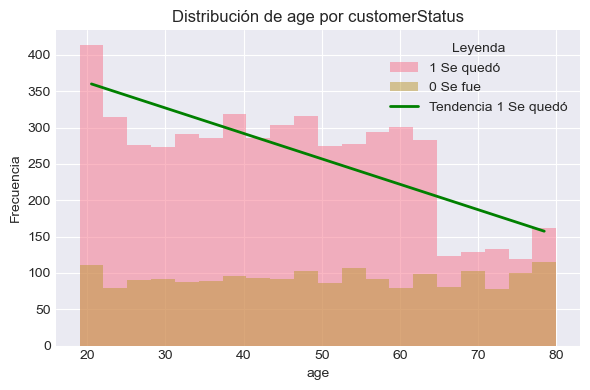

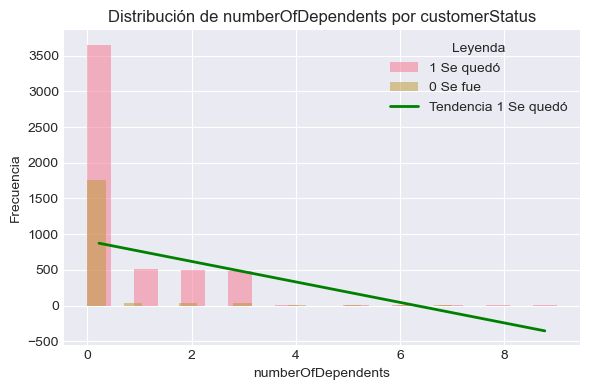

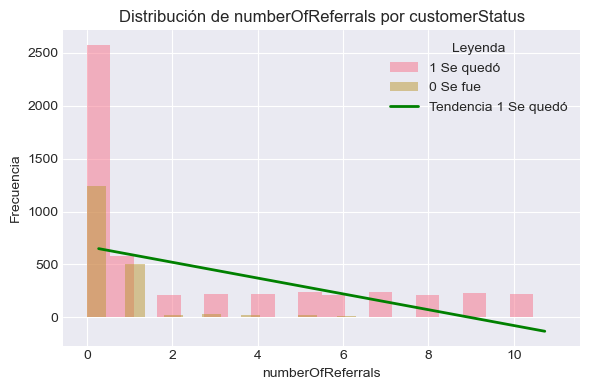

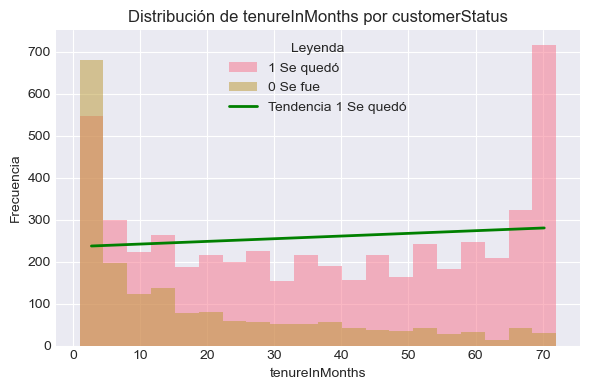

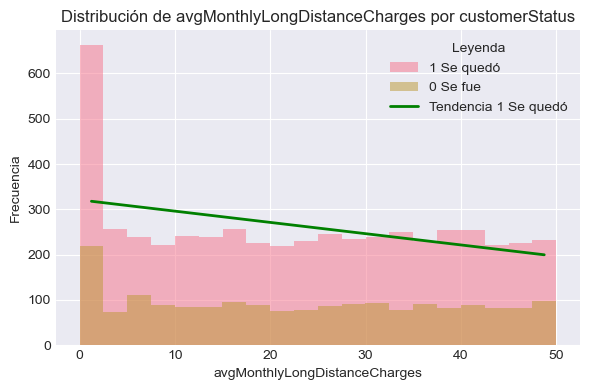

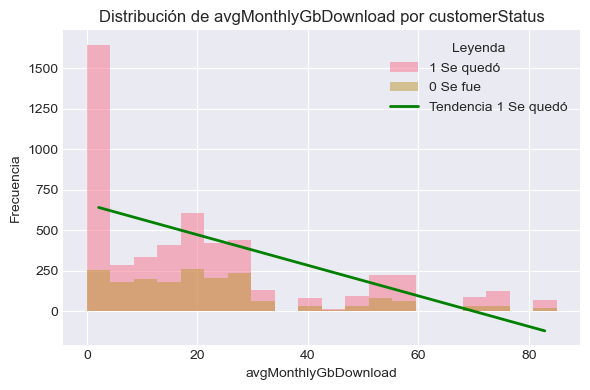

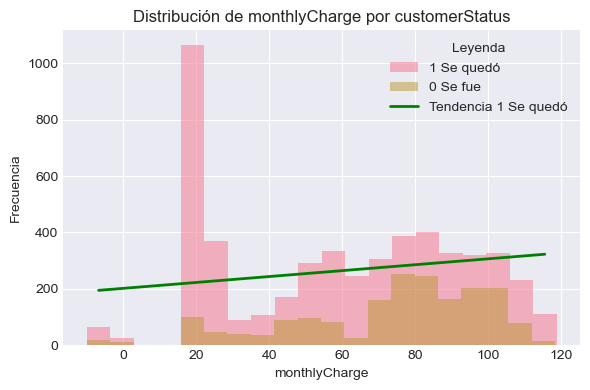

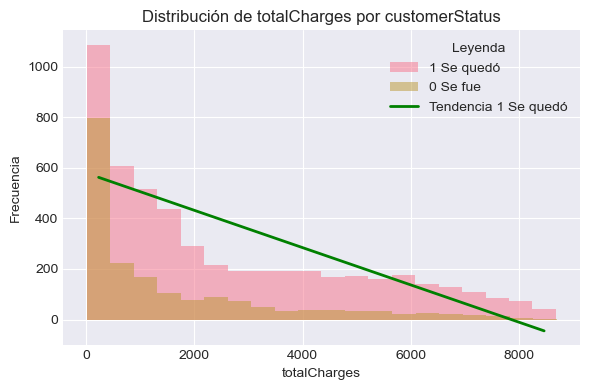

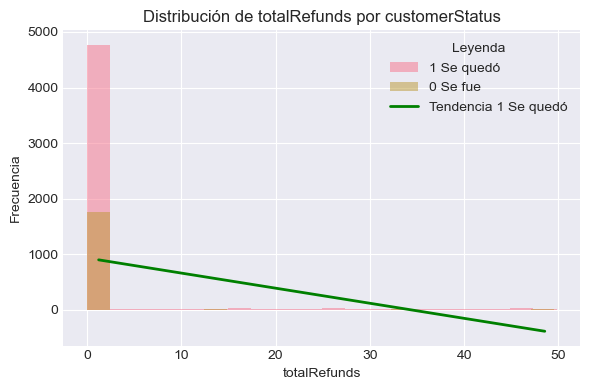

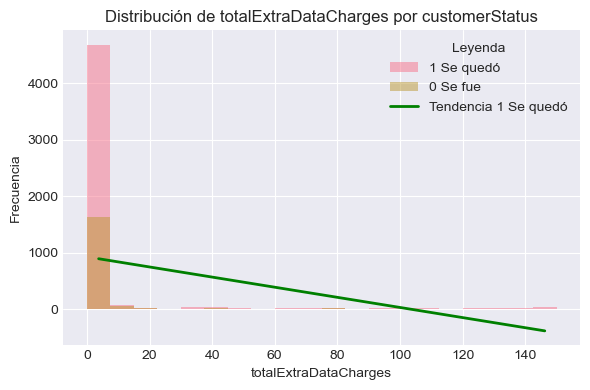

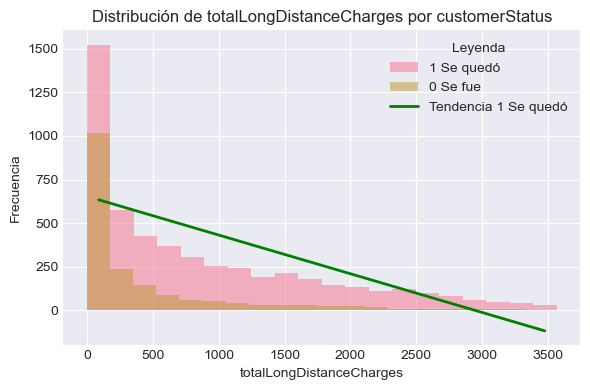

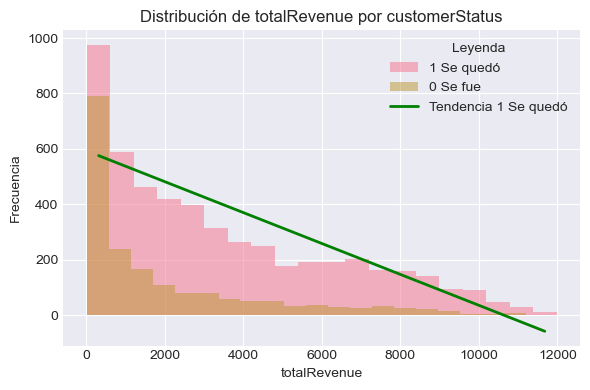

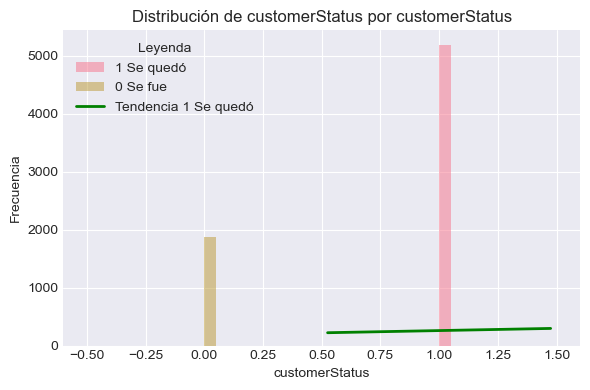

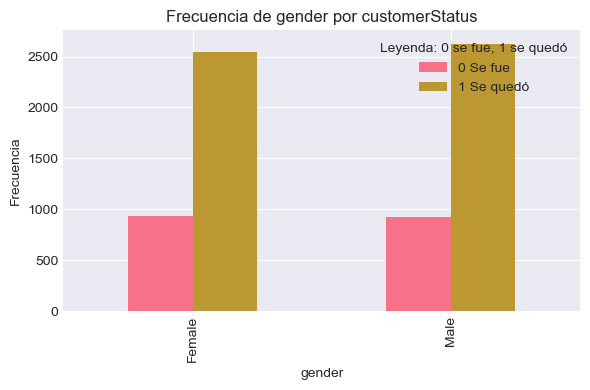

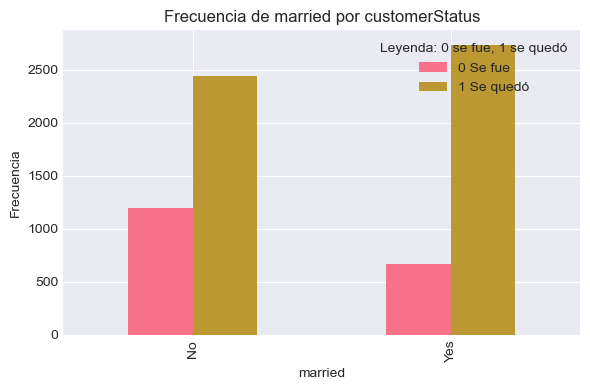

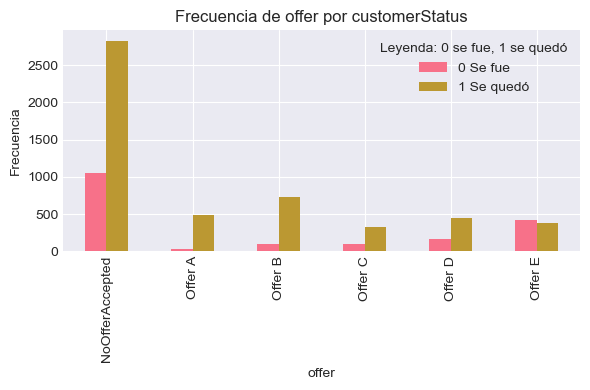

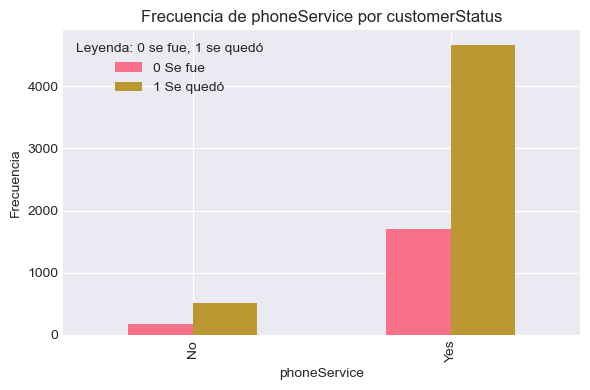

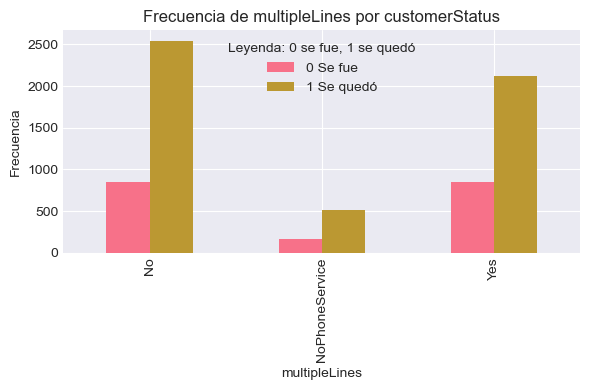

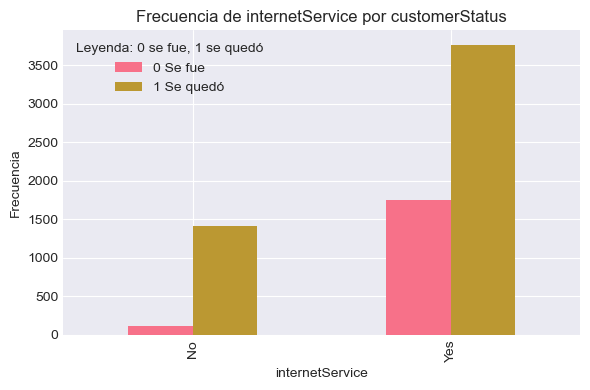

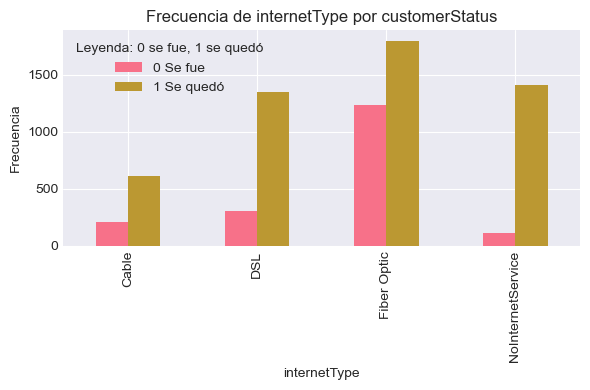

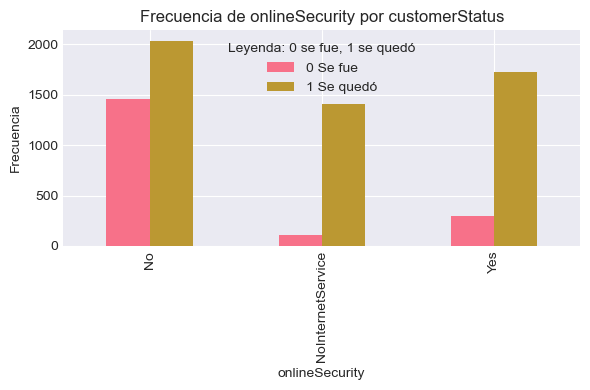

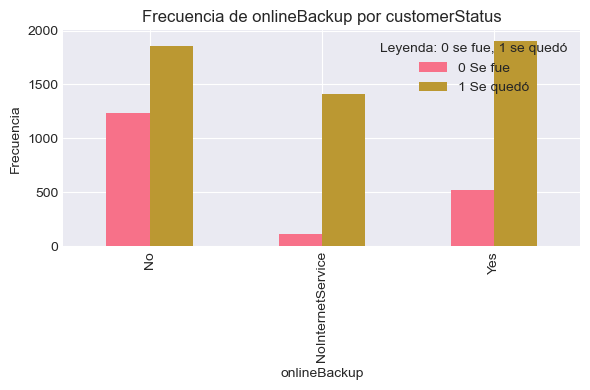

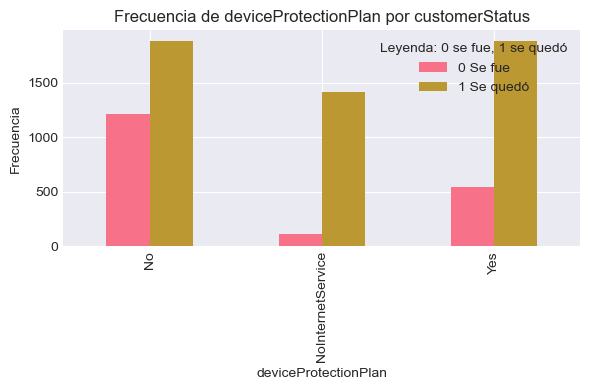

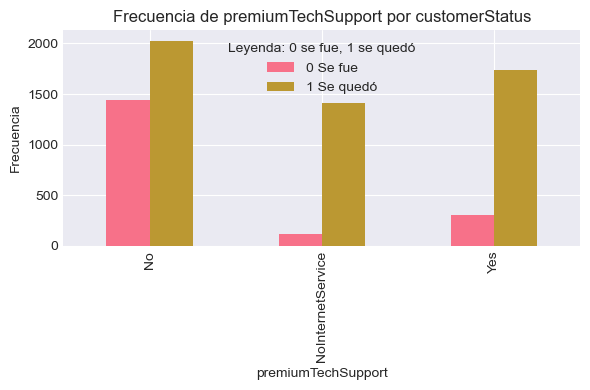

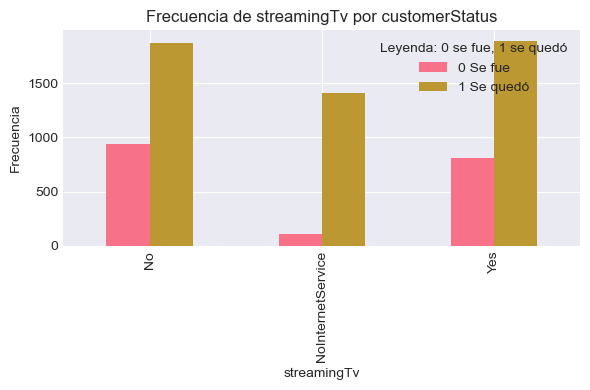

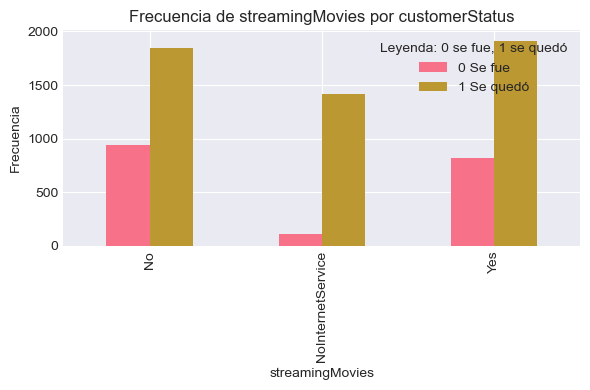

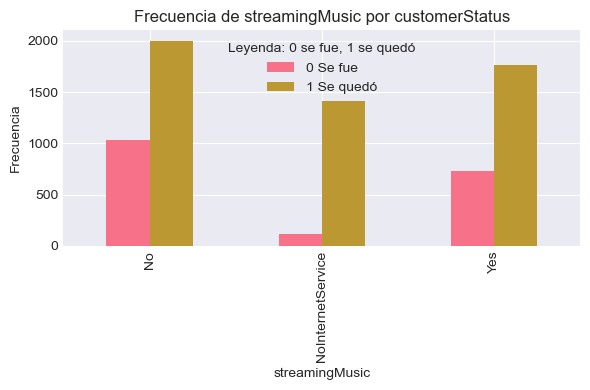

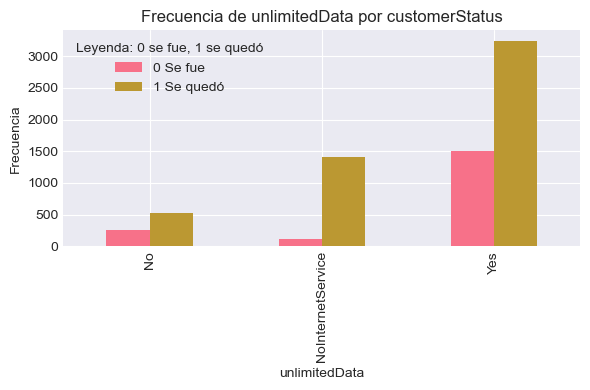

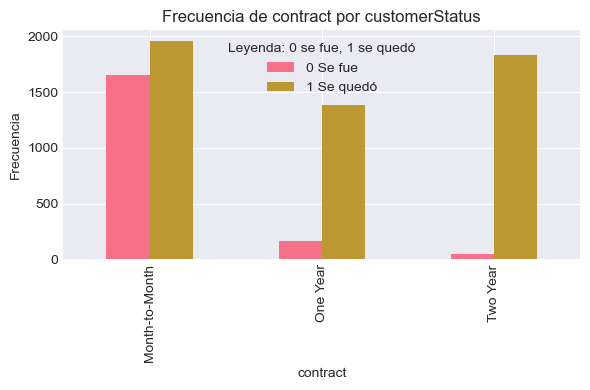

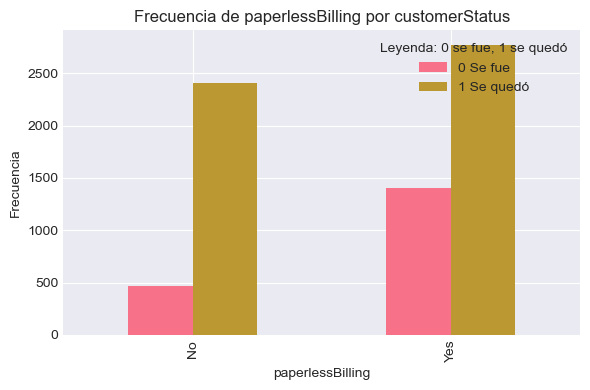

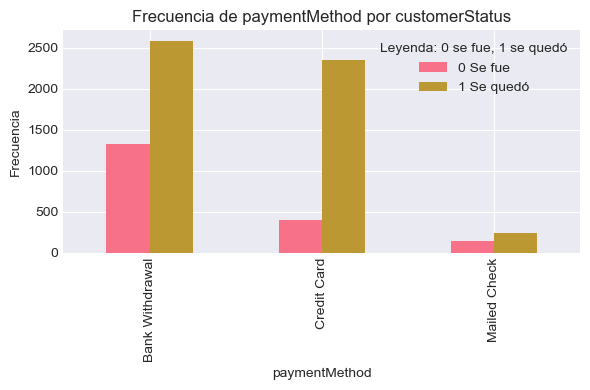

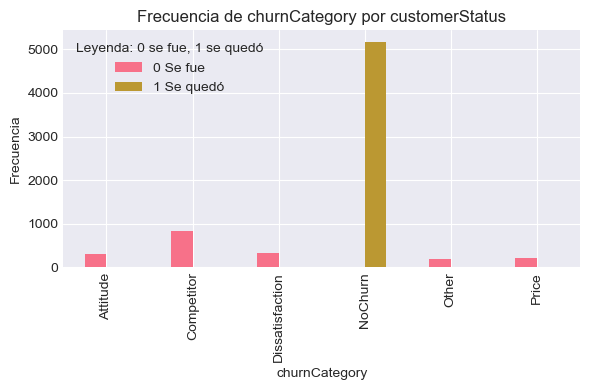

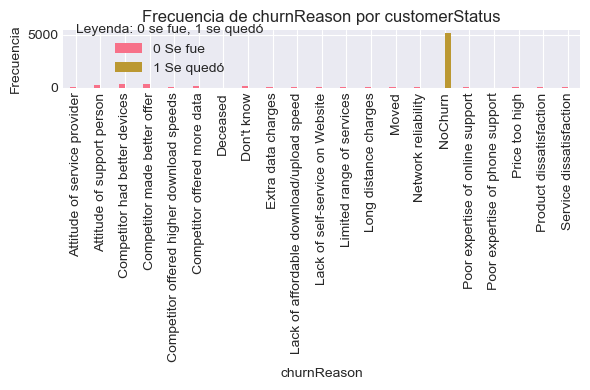

In [133]:
# Graficar diagramas de frecuencia para variables numéricas y no numéricas,
# diferenciando por customerStatus

import matplotlib.pyplot as plt
import numpy as np

# Seleccionar variables numéricas y categóricas (excluyendo customerStatus)
num_vars = df_test_copy.select_dtypes(include=['number']).columns.tolist()
cat_vars = df_test_copy.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
if 'customerStatus' in cat_vars:
    cat_vars.remove('customerStatus')

# Definir mapeo para leyenda
status_legend_map = {
    0: '0 Se fue',
    1: '1 Se quedó'
}

# Si customerStatus es string/categoría, intentar mapear a 0/1 para leyenda
unique_status = df_test_copy['customerStatus'].unique()
status_labels = {}
for status in unique_status:
    # Si es numérico 0/1
    if status in status_legend_map:
        status_labels[status] = status_legend_map[status]
    # Si es string, mapear manualmente
    elif str(status).lower() in ['churned', 'se fue', 'no', 'left']:
        status_labels[status] = '0 Se fue'
    elif str(status).lower() in ['stayed', 'se quedo', 'yes', 'quedó', 'joined']:
        status_labels[status] = '1 Se quedó'
    else:
        status_labels[status] = str(status)

# Gráficos para variables numéricas
for col in num_vars:
    plt.figure(figsize=(6,4))
    for status in unique_status:
        subset = df_test_copy[df_test_copy['customerStatus'] == status]
        plt.hist(subset[col].dropna(), bins=20, alpha=0.5, label=status_labels.get(status, str(status)))
    # Añadir línea de tendencia de grado 1 para los que se quedan (1 o 'Stayed', etc)
    # Buscar el valor de status que corresponde a "1 Se quedó"
    status_1_keys = [k for k, v in status_labels.items() if v == '1 Se quedó']
    if status_1_keys:
        status_1 = status_1_keys[0]
        subset_1 = df_test_copy[df_test_copy['customerStatus'] == status_1][col].dropna()
        if len(subset_1) > 1:
            # Calcular histograma para la línea de tendencia
            counts, bin_edges = np.histogram(subset_1, bins=20)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            # Ajustar una línea polinómica de grado 1 (recta)
            z = np.polyfit(bin_centers, counts, 1)
            p = np.poly1d(z)
            plt.plot(bin_centers, p(bin_centers), color='green', linewidth=2, label='Tendencia 1 Se quedó')
    plt.title(f'Distribución de {col} por customerStatus')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend(title="Leyenda")
    plt.tight_layout()
    plt.show()

# Gráficos para variables categóricas
for col in cat_vars:
    plt.figure(figsize=(6,4))
    cross = df_test_copy.groupby([col, 'customerStatus']).size().unstack(fill_value=0)
    # Renombrar columnas de la tabla cruzada para la leyenda
    cross_renamed = cross.rename(columns=status_labels)
    cross_renamed.plot(kind='bar', stacked=False, ax=plt.gca())
    plt.title(f'Frecuencia de {col} por customerStatus')
    plt.ylabel('Frecuencia')
    plt.xlabel(col)
    plt.legend(title="Leyenda: 0 se fue, 1 se quedó")
    plt.tight_layout()
    plt.show()


In [80]:
print(df_test_copy['streamingTv'].value_counts())
print(df_test_copy['streamingMovies'].value_counts())
print(df_test_copy['streamingMusic'].value_counts())
print(df_test_copy['unlimitedData'].value_counts())
print(df_test_copy['onlineSecurity'].value_counts())
print(df_test_copy['onlineBackup'].value_counts())
print(df_test_copy['deviceProtectionPlan'].value_counts())
print(df_test_copy['premiumTechSupport'].value_counts())

streamingTv
No                   2810
Yes                  2707
NoInternetService    1526
Name: count, dtype: int64
streamingMovies
No                   2785
Yes                  2732
NoInternetService    1526
Name: count, dtype: int64
streamingMusic
No                   3029
Yes                  2488
NoInternetService    1526
Name: count, dtype: int64
unlimitedData
Yes                  4745
NoInternetService    1526
No                    772
Name: count, dtype: int64
onlineSecurity
No                   3498
Yes                  2019
NoInternetService    1526
Name: count, dtype: int64
onlineBackup
No                   3088
Yes                  2429
NoInternetService    1526
Name: count, dtype: int64
deviceProtectionPlan
No                   3095
Yes                  2422
NoInternetService    1526
Name: count, dtype: int64
premiumTechSupport
No                   3473
Yes                  2044
NoInternetService    1526
Name: count, dtype: int64


### Ingeniera de características


In [134]:
# Contar servicios de entretenimiento, no asumir que se deban eliminar las indivuales, la que me da mejor la mejor respues es para modelar.
df_test_copy['entertainment_services_count'] = (
    df_test_copy['streamingTv'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['streamingMovies'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['streamingMusic'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['unlimitedData'].map({'Yes': 1}).fillna(0).astype(int)
)

# Contar servicios de protección
df_test_copy['protection_services_count'] = (
    df_test_copy['onlineSecurity'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['onlineBackup'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['deviceProtectionPlan'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['premiumTechSupport'].map({'Yes': 1}).fillna(0).astype(int)
)

# Total de servicios adicionales
df_test_copy['total_addon_services'] = df_test_copy['entertainment_services_count'] + df_test_copy['protection_services_count']

# Perfil de consumidor, viene bien dar la transformacion las variables. Sofre esfuerzo en combinaciones complejas hay modelos que ya encuentran las interacciones por defecto.
def consumer_profile(row):
    ent = row['entertainment_services_count']
    prot = row['protection_services_count']
    
    if ent >= 3 and prot >= 2: return 'Premium_All'
    elif ent >= 2: return 'Entertainment_Heavy'
    elif prot >= 2: return 'Security_Conscious'
    elif ent >= 1 or prot >= 1: return 'Moderate_User'
    else: return 'Basic_Only'

df_test_copy['consumer_profile'] = df_test_copy.apply(consumer_profile, axis=1)

# Propensión al exceso de uso
df_test_copy['data_overage_propensity'] = df_test_copy['totalExtraDataCharges'] / np.maximum(df_test_copy['totalCharges'], 1)
df_test_copy['longdist_usage_propensity'] = df_test_copy['totalLongDistanceCharges'] / np.maximum(df_test_copy['totalCharges'], 1)

# Indicador de usuario intensivo
df_test_copy['heavy_user'] = np.where(
    (df_test_copy['totalExtraDataCharges'] > 0) | (df_test_copy['avgMonthlyGbDownload'] > df_test_copy['avgMonthlyGbDownload'].quantile(0.75)),
    'Heavy', 'Normal'
)

# Ratio de servicios vs tenure (adopción temprana vs tardía)
df_test_copy['service_adoption_rate'] = df_test_copy['total_addon_services'] / np.maximum(df_test_copy  ['tenureInMonths'], 1)

df_test_copy['base_revenue'] = df_test_copy['totalCharges'] - df_test_copy['totalExtraDataCharges'] - df_test_copy['totalLongDistanceCharges']
df_test_copy['usage_revenue'] = df_test_copy['totalExtraDataCharges'] + df_test_copy['totalLongDistanceCharges']
df_test_copy['usage_revenue_ratio'] = df_test_copy['usage_revenue'] / np.maximum(df_test_copy['totalRevenue'], 1)

def profitability_tier(revenue_value, revenue_series):
    if revenue_value > revenue_series.quantile(0.8): 
        return 'High_Value'
    elif revenue_value > revenue_series.quantile(0.6): 
        return 'Medium_High'
    elif revenue_value > revenue_series.quantile(0.4): 
        return 'Medium'
    elif revenue_value > revenue_series.quantile(0.2): 
        return 'Medium_Low'
    else: 
        return 'Low_Value'

df_test_copy['value_tier'] = df_test_copy['totalRevenue'].apply(
    lambda x: profitability_tier(x, df_test_copy['totalRevenue'])
)

modelo_final_corregido = [
    # Core business metrics
    'tenureInMonths',
    'totalRevenue',
    'contract',
    
    # Service adoption pattern
    'consumer_profile',          # En lugar de servicios individuales
    'entertainment_services_count',
    'protection_services_count',
    
    # Usage behavior  
    'data_overage_propensity',
    'heavy_user',
    'multipleLines',            # Sí es independiente
    
    # Social & promotional
    'numberOfReferrals',
    'offer',
]

In [135]:
todas_columnas_X = modelo_final_corregido
print("Cantidad de valores NA por columna en df_test_copy:")
print(df_test_copy.isna().sum())
df_test_copy.customerStatus.value_counts()



Cantidad de valores NA por columna en df_test_copy:
gender                           0
age                              0
married                          0
numberOfDependents               0
numberOfReferrals                0
tenureInMonths                   0
offer                            0
phoneService                     0
avgMonthlyLongDistanceCharges    0
multipleLines                    0
internetService                  0
internetType                     0
avgMonthlyGbDownload             0
onlineSecurity                   0
onlineBackup                     0
deviceProtectionPlan             0
premiumTechSupport               0
streamingTv                      0
streamingMovies                  0
streamingMusic                   0
unlimitedData                    0
contract                         0
paperlessBilling                 0
paymentMethod                    0
monthlyCharge                    0
totalCharges                     0
totalRefunds                     0
tot

customerStatus
1    5174
0    1869
Name: count, dtype: int64

In [137]:
from sklearn.preprocessing import LabelEncoder

X = df_test_copy[todas_columnas_X]
y = df_test_copy['customerStatus']

# Identificar columnas categóricas en X
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar LabelEncoder a cada columna categórica
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le  # Guardar el encoder por si se necesita después

# 8. División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [139]:

###pimer modelo entrenado
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # o 'multi:softprob' si son más de 2 clases
    random_state=42,
    n_estimators=100,           # Empezar con pocos árboles
    max_depth=6,               # Profundidad moderada
    learning_rate=0.1,         # Learning rate estándar
    subsample=0.8,             # Submuestreo para evitar overfitting
    colsample_bytree=0.8,      # Submuestreo de features
    scale_pos_weight=1,        # Ajustaremos si hay desbalance
    eval_metric='logloss'      # Métrica de evaluación
)

# 3.2 Entrenar modelo
xgb_model.fit(X_train, y_train)

# 3.3 Predicciones
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

print("Modelo básico entrenado")

# 4.1 F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' para multiclase
print(f"F1 Score: {f1:.4f}")

# 4.2 Reporte completo
print("\nReporte de clasificación:")
target_names = ['Se fue', 'Se quedo']  

print(classification_report(y_test, y_pred, target_names=target_names))

# 4.3 Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# 4.4 F1 por clase (si es multiclase)
f1_per_class = f1_score(y_test, y_pred, average=None)
for i, clase in enumerate(target_names):
    print(f"F1 {clase}: {f1_per_class[i]:.4f}")




Modelo básico entrenado
F1 Score: 0.8267

Reporte de clasificación:
              precision    recall  f1-score   support

      Se fue       0.69      0.64      0.66       374
    Se quedo       0.87      0.90      0.89      1035

    accuracy                           0.83      1409
   macro avg       0.78      0.77      0.77      1409
weighted avg       0.83      0.83      0.83      1409


Matriz de confusión:
[[239 135]
 [106 929]]
F1 Se fue: 0.6648
F1 Se quedo: 0.8852


In [140]:
class_counts = np.bincount(y_train)
if len(class_counts) == 2:  # Clasificación binaria
    ratio = class_counts[0] / class_counts[1]
    print(f"Ratio de desbalance: {ratio:.2f}")
    
    # 5.2 Ajustar scale_pos_weight
    xgb_balanced = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=ratio,  # Ajuste para desbalance
        eval_metric='logloss'
    )
    
    xgb_balanced.fit(X_train, y_train)
    y_pred_balanced = xgb_balanced.predict(X_test)
    f1_balanced = f1_score(y_test, y_pred_balanced, average='weighted')
    
    print(f"F1 con ajuste de balance: {f1_balanced:.4f}")

Ratio de desbalance: 0.36
F1 con ajuste de balance: 0.8157


In [141]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# 6.2 Configurar GridSearch con F1 como métrica
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        scale_pos_weight=ratio if 'ratio' in locals() else 1
    ),
    param_grid=param_grid,
    scoring='f1_weighted',  # Optimizar para F1
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,             # Usar todos los cores
    verbose=1
)

print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1 CV: {grid_search.best_score_:.4f}")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejores parámetros: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Mejor F1 CV: 0.8014


In [142]:
# 7.2 Predicciones finales
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)
y_pred_proba_final = best_model.predict_proba(X_test)

# 7.3 Evaluación final
f1_final = f1_score(y_test, y_pred_final, average='weighted')
print(f"\nF1 Score final: {f1_final:.4f}")

print("\nReporte final:")
print(classification_report(y_test, y_pred_final, target_names=target_names))


F1 Score final: 0.8098

Reporte final:
              precision    recall  f1-score   support

      Se fue       0.60      0.78      0.68       374
    Se quedo       0.91      0.81      0.86      1035

    accuracy                           0.80      1409
   macro avg       0.75      0.79      0.77      1409
weighted avg       0.83      0.80      0.81      1409



In [143]:
# 8.1 Cross-validation para validar estabilidad del F1
cv_f1_scores = cross_val_score(
    best_model, X_train, y_train, 
    cv=5, scoring='f1_weighted'
)

print(f"\nF1 Scores CV: {cv_f1_scores}")
print(f"F1 promedio CV: {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std() * 2:.4f})")


F1 Scores CV: [0.80817213 0.80052815 0.79591898 0.78613243 0.8086675 ]
F1 promedio CV: 0.7999 (+/- 0.0168)



Top 10 features más importantes:
                        feature  importance
2                      contract    0.546168
9             numberOfReferrals    0.116975
4  entertainment_services_count    0.054781
3              consumer_profile    0.041363
0                tenureInMonths    0.038125
8                 multipleLines    0.036519
5     protection_services_count    0.036172
6       data_overage_propensity    0.035238
1                  totalRevenue    0.033044
7                    heavy_user    0.032894


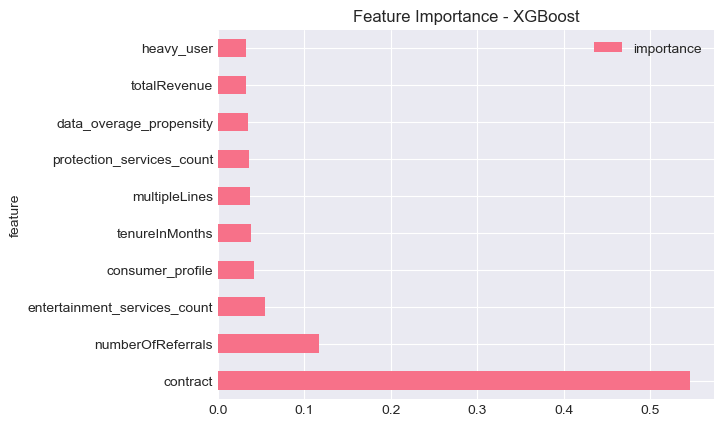

In [144]:
# 9.1 Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features más importantes:")
print(feature_importance.head(10))

# 9.2 Plot de importancia (opcional)

feature_importance.head(10).plot(x='feature', y='importance', kind='barh')
plt.title('Feature Importance - XGBoost')
plt.show()

### Conclusiones

Dado el objetivo planteado de disminuir el Churned, la variable dependiente es Customer Status, pero también podría ser Teneru in Months si quisieramos predicir el tiempo de permanencia, u Offer si quisieramos predecir la mejor oferta aceptada por el cliente.

Se evaluó la variable categórica objetivo Customer Status que tenia 3 valores: Se quedó (Stayed 67%), Se unió (Joined 6.4%) y se fue (Chuned 26.5%). Para la clasificación se optó por transformar los valores de Joined a stayed , quedando solo 2 valores Not Churned y Churned. 

Se eliminó los valores nulos o vacios al tener en cuenta que los clientes que no tienen servicio de internet tenían estas características vacias: internetType, onlineBackup, onlineSecurity, deviceProtectionPlan, premiumTechSupport, streamingTv, streamingMovies, streamingMusic, unlimitedData, todas las columnas relacionadas () se marcan como 'NoInternetService'.De forma similar, cuando no hay servicio telefónico, la columna multipleLines se marca como 'NoPhoneService'. Para las ofertas faltantes se usa 'NoOfferAccepted', y para clientes que stayed o Joined se marca churnCategory y churnReason como 'NoChurn'. Finalmente se elimina la columna customerId del dataset que sirve para identificar al cliente.

Valor monetario de las 1869 personas con Churned es 3 684 459.82 USA que es el 17% del revenue total, que representa el 26.5% de las personas.

Las mejores variables predictoras son el tipo de contrato, número de referidos y el tiempo de cliente.

Entre 1 y 10 meses de estar en la empresa son las personas con mayor porcentaje de Churned, las personas con más churned son que no han dado referidos, dao que mientras mas satisfacción haya, es más probable que se quede. Asimimos, que tienen contrato mensual, que retira dinero del banco, paga entre 70 y 120 USA, y entre 65 y 80 años.

En relación a las ofertas, las A,B,C y D mucha mayor proposición a stayed y las E, tiene un Churned mayor a Stayed. A los que recién se han unido joined solo ha ofertes E.

En las correlaciones númericas se encontró una alta  entre  totalCharges y totalRevenue, que se explica dado que la segunda esta en función de la primera. 



